### CRC183 Summer School "Machine Learning in Condensed Matter Physics"
# Hands-on session: Learning the classical Ising transition

Run this cell, if you are running the notebook on Google Colab:

In [ ]:
!git clone https://github.com/CRC183-summer-school/school_2021.git

In [ ]:
!pip install flax

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# To measure the time it takes to train a network
import time

# Everything we need from JAX
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.scipy.special import logsumexp # Computes the log of the sum of exponentials of input elements.
from jax.experimental import optimizers

# Flax module for deep learning models
import flax.linen as nn

import sys
sys.path.append(sys.path[0] + "./school_2021/notebooks/")

from IsingData import generate_Ising_configurations

# The key for our random number generator, we need this because JAX will distribute the calculation
key = random.PRNGKey(0)

# Generate training data

In [2]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = generate_Ising_configurations(10, 1000, Ts)

Generating samples for L = 10 at T = 4.426
Generating samples for L = 10 at T = 4.199
Generating samples for L = 10 at T = 3.972
Generating samples for L = 10 at T = 3.745
Generating samples for L = 10 at T = 3.518
Generating samples for L = 10 at T = 3.291
Generating samples for L = 10 at T = 3.064
Generating samples for L = 10 at T = 2.837
Generating samples for L = 10 at T = 2.610
Generating samples for L = 10 at T = 2.383
Generating samples for L = 10 at T = 2.156
Generating samples for L = 10 at T = 1.929
Generating samples for L = 10 at T = 1.702
Generating samples for L = 10 at T = 1.475
Generating samples for L = 10 at T = 1.248
Generating samples for L = 10 at T = 1.021
Generating samples for L = 10 at T = 0.794
Generating samples for L = 10 at T = 0.567
Generating samples for L = 10 at T = 0.340
Generating samples for L = 10 at T = 0.113


## Split the training data

In [3]:
def get_training_data(all_data, Ts, Tc=2.7, train_fraction=0.8):
    # Lists to store the raw data
    raw_T = []
    raw_x = []
    raw_y = [] 
    
    for T in Ts:      
        raw_x.append(all_data['%.3f'%(T)])
        n = len(all_data['%.3f'%(T)])
        label = [1,0] if T < Tc else [0,1]
        raw_y.append(np.array([label] * n))
        raw_T.append(np.array([T]*n))
        
    raw_T = np.concatenate(raw_T)
    raw_x = np.concatenate(raw_x, axis=0)
    raw_y = np.concatenate(raw_y, axis=0)
    
    # Shuffle
    indices = np.random.permutation(len(raw_x))
    all_T = raw_T[indices]
    all_x = raw_x[indices]
    all_y = raw_y[indices]

    # Split into train and test sets
    train_split = int(train_fraction * len(all_x))
    train_T = jnp.array(all_T[:train_split])
    train_x = jnp.array(all_x[:train_split])
    train_y = jnp.array(all_y[:train_split])
    test_T = jnp.array(all_T[train_split:])
    test_x = jnp.array(all_x[train_split:])
    test_y = jnp.array(all_y[train_split:])
    
    return [raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y]

### Visualize some data samples

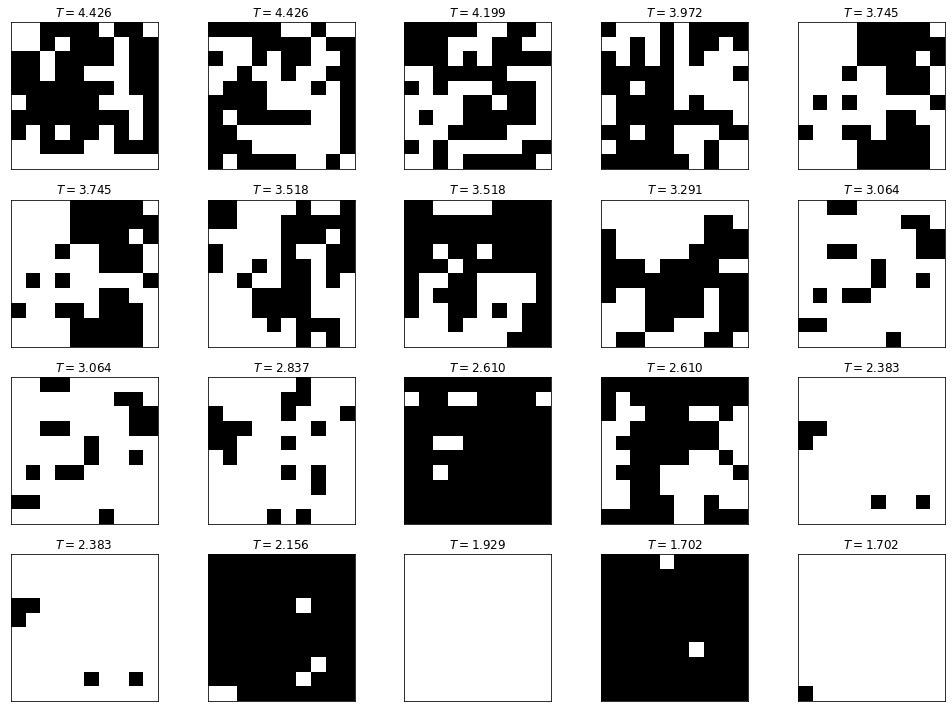

In [4]:
[raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = get_training_data(all_data,Ts)

fig, ax = plt.subplots(4,5, figsize=(14,10))
for i in range(4):
    for j in range(5):
        ax[i,j].matshow(np.reshape(raw_x[(4*i + j)*800], (10,10)), cmap='Greys')
        ax[i,j].set_title("$T = %.3f$"%raw_T[(4*i + j)*800])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
fig.tight_layout()

## Make a Feedforward network

In [5]:
from typing import Sequence

class MyNet(nn.Module):
    layers: Sequence[int] # A tuple that contains the widths of all layers follwing the input layer
    
    @nn.compact
    def __call__(self, x):

        a = x.ravel() # flatten the input

        # Evaluate network layer by layer
        for width in self.layers[:-1]:
            # Apply a the Dense layer with given width followed by the non-linearity
            a = nn.relu(nn.Dense(width)(a))
          
        a = nn.Dense(self.layers[-1])(a)
        
        # Return activations of the output layer
        return a - logsumexp(a)
    
# Initialize a new network (or rather its parameters)
layer_sizes = [100, 64, 32, 2]
net = MyNet(layers=layer_sizes)

### Define the forward prediction of our network

In [26]:
# Make a batched `predict` function
predict = jax.vmap(lambda p, x: net.apply(p,x), in_axes=(None, 0), out_axes=0)

## The loss function

In [20]:
def loss(params, images, targets):
    preds = predict(params, images)
    return -jnp.mean(preds * targets)

## The optimizer

In [21]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

## Training loop

In [22]:
def accuracy(params, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def train(train_x, train_y, test_x, test_y, num_epochs, batch_size, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_x, train_y)
    test_acc = accuracy(params, test_x, test_y)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Divide into batches
    num_batches = len(train_x) // batch_size

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Shuffle data
        indices = np.random.permutation(len(train_x))
        batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)
        
        for b in range(len(batch_indices)):
            x = train_x[batch_indices[b]]
            y = train_y[batch_indices[b]]
            
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_x, train_y)
        test_acc = accuracy(params, test_x, test_y)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | Time: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))

        
    return train_loss, log_acc_train, log_acc_test, params

# Blanking: train model in known limits, then use it to predict the rest

In [10]:
# Pick only the Ts at the beginning and at the end, and construct a dataset
train_Ts = list(Ts[:4]) + list(Ts[-4:])
[raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = get_training_data(all_data, train_Ts)

# Initialize a new network (or rather its parameters)
params = MyNet(layers=layer_sizes).init(key, train_x[0])

# Initialize the optimizer
opt_state = opt_init(params)

Epoch 1 | Time: 0.99 | Train A: 1.000 | Test A: 1.000
Epoch 2 | Time: 0.08 | Train A: 1.000 | Test A: 1.000
Epoch 3 | Time: 0.08 | Train A: 1.000 | Test A: 1.000
Epoch 4 | Time: 0.08 | Train A: 1.000 | Test A: 1.000
Epoch 5 | Time: 0.08 | Train A: 1.000 | Test A: 1.000
Epoch 6 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 7 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 8 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 9 | Time: 0.13 | Train A: 1.000 | Test A: 1.000
Epoch 10 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 11 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 12 | Time: 0.07 | Train A: 1.000 | Test A: 1.000
Epoch 13 | Time: 0.08 | Train A: 1.000 | Test A: 1.000
Epoch 14 | Time: 0.08 | Train A: 1.000 | Test A: 1.000
Epoch 15 | Time: 0.07 | Train A: 1.000 | Test A: 1.000
Epoch 16 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 17 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 18 | Time: 0.09 | Train A: 1.000 | Test A: 1.000
Epoch 19 | Time: 0.

Text(0, 0.5, 'Loss')

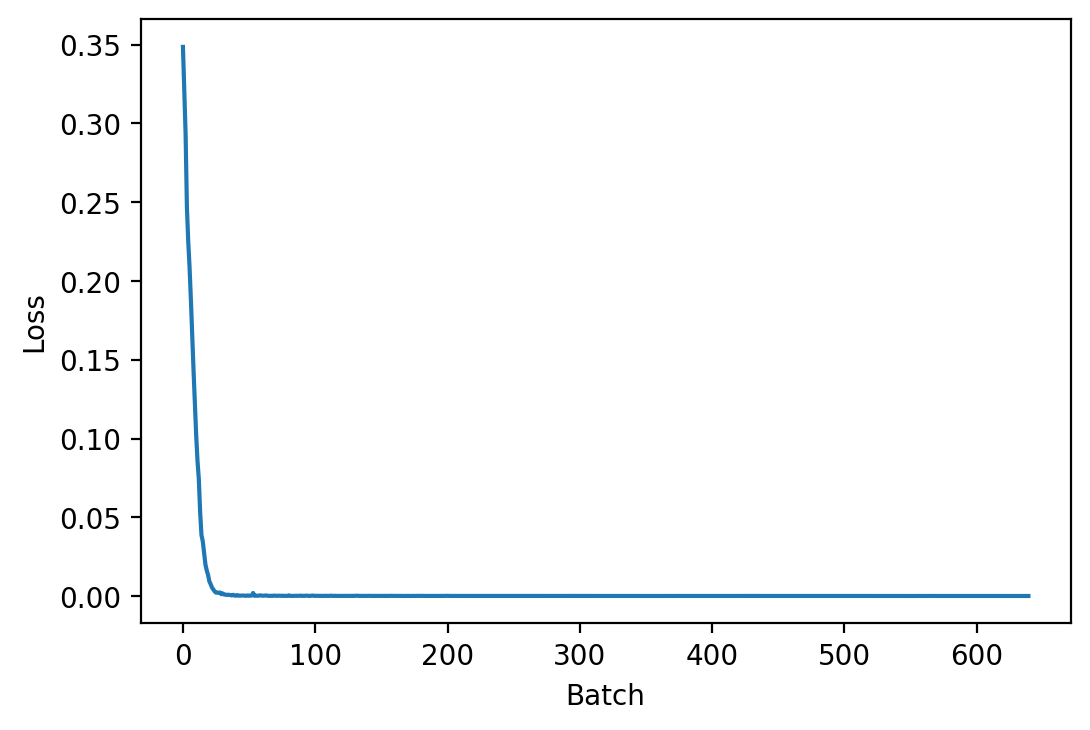

In [11]:
train_loss, train_log, test_log, params = train(train_x, train_y, test_x, test_y, 20, 32, opt_state)

fig, ax = plt.subplots(dpi=200)
ax.plot(train_loss)
ax.set_xlabel("Batch")
ax.set_ylabel("Loss")

## Predict for all Ts

In [12]:
# For every temperature, get the averaged prediction
predictions = []
for T in Ts:
    x = all_data['%.3f'%T]#['x']
    p = jnp.exp( predict(params, x) )  # Exponentiate it to go back to the [0,1] range for nicer plotting
    p = jnp.mean( p, axis=0 )
    predictions.append(p)

Text(0, 0.5, 'Predictions')

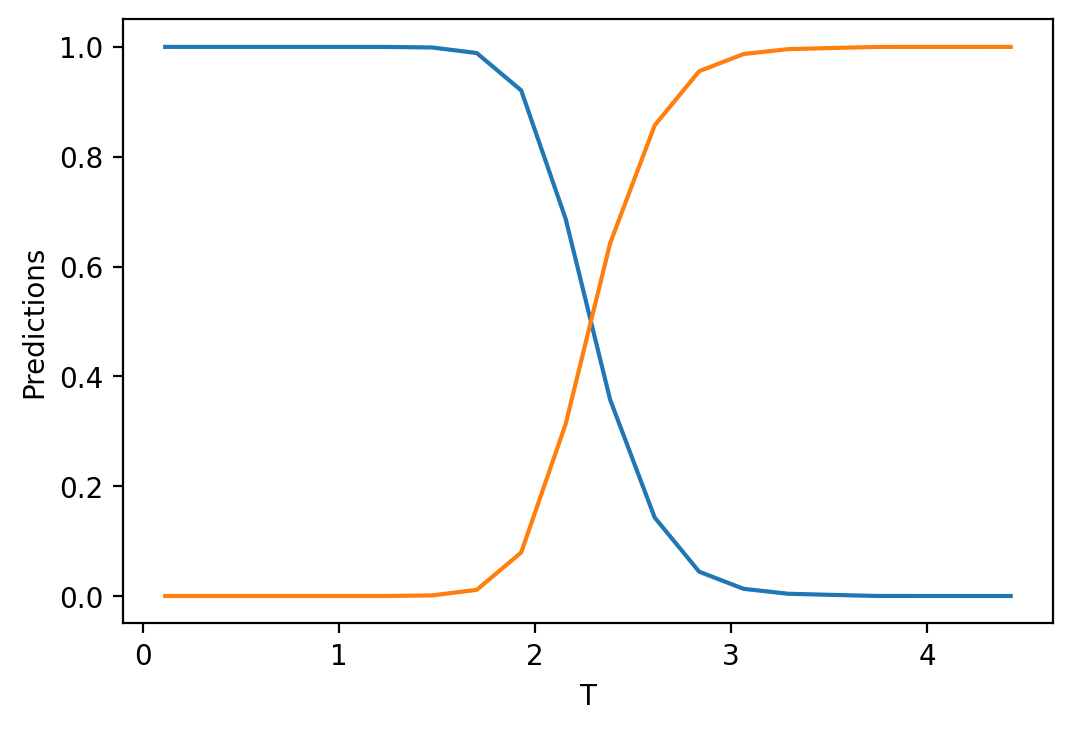

In [13]:
fig, ax = plt.subplots(dpi=200)
ax.plot( Ts, predictions )
ax.set_xlabel("T")
ax.set_ylabel("Predictions")

# Challenge ideas:

In [ ]:
# Fit a sigmoid to the outputs to extract the crossing point (=Tc)
# See how the crossing point depends on:
    # The (width of the) regions in which you train
    # The network architecture
    # Size of the data (instead of 10x10 snapshots)
    
# Convert to use a Flax model

# Learning by confusion

In [58]:
def train_with_guess(Ts, Tc_guess):
    [raw_T, raw_x, raw_y], [train_T, train_x, train_y], [test_T, test_x, test_y] = get_training_data(all_data, Ts, Tc=Tc_guess, train_fraction=0.9)
    
    # Initialize a new network (or rather its parameters)
    params = MyNet(layers=layer_sizes).init(key, train_x[0])

    # Initialize the optimizer
    opt_state = opt_init(params)

    train_loss, train_log, test_log, params = train(train_x, train_y, test_x, test_y, 5, 16, opt_state)
    
    return train_log

In [59]:
W_over_time = {}
for guess in np.linspace(Ts[0], Ts[-1], 10):
    print("Training at guess %.3f"%guess)
    accuracy_vs_epoch = train_with_guess(Ts, guess)
    W_over_time[guess] = accuracy_vs_epoch
    print("\t Final accuracy: %.3f"%accuracy_vs_epoch[-1])

Training at guess 4.426
Epoch 1 | Time: 0.06 | Train A: 0.949 | Test A: 0.956
Epoch 2 | Time: 0.05 | Train A: 0.949 | Test A: 0.956
Epoch 3 | Time: 0.06 | Train A: 0.949 | Test A: 0.956
Epoch 4 | Time: 0.06 | Train A: 0.949 | Test A: 0.956
Epoch 5 | Time: 0.07 | Train A: 0.949 | Test A: 0.956
	 Final accuracy: 0.949
Training at guess 3.947
Epoch 1 | Time: 0.06 | Train A: 0.850 | Test A: 0.846
Epoch 2 | Time: 0.06 | Train A: 0.854 | Test A: 0.842
Epoch 3 | Time: 0.06 | Train A: 0.858 | Test A: 0.850
Epoch 4 | Time: 0.06 | Train A: 0.865 | Test A: 0.850
Epoch 5 | Time: 0.06 | Train A: 0.869 | Test A: 0.853
	 Final accuracy: 0.869
Training at guess 3.468
Epoch 1 | Time: 0.06 | Train A: 0.857 | Test A: 0.845
Epoch 2 | Time: 0.05 | Train A: 0.869 | Test A: 0.860
Epoch 3 | Time: 0.06 | Train A: 0.874 | Test A: 0.863
Epoch 4 | Time: 0.06 | Train A: 0.877 | Test A: 0.861
Epoch 5 | Time: 0.06 | Train A: 0.879 | Test A: 0.862
	 Final accuracy: 0.879
Training at guess 2.989
Epoch 1 | Time: 0.06 |

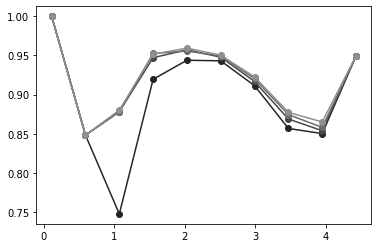

In [61]:
guess_Ts = np.linspace(Ts[0], Ts[-1], 10)

for i in range(1,5):
    curve = [W_over_time[guess][i] for guess in guess_Ts]
    color = np.array([0.7, 0.7, 0.7])*i/5
    plt.plot( guess_Ts, curve, '-o', c=color )

## Challenge ideas

* Play with the hyperparameters to build intuition, see if you can get a clear W shape
* Increase the temperature resolution
* Increase the number of epochs trained for, you should be able to see the W become more flat -> why is this?